In [1]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import *
import math
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt
import cufflinks as cf
import plotly.plotly as py
import plotly.graph_objs as go

In [59]:
# read dataset
df=pd.read_csv("../data/Demandv1.1.csv")

## Exploratory Data Analysis

In [3]:
df.columns

Index(['Region', 'Employee Code', '  Last Name', 'Local Date of Joining',
       'Designation', 'Status', 'Market Unit', 'SkillList', 'Location'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Region                   10000 non-null object
Employee Code            10000 non-null int64
  Last Name              10000 non-null object
Local Date of Joining    10000 non-null object
Designation              9992 non-null object
Status                   10000 non-null object
Market Unit              9859 non-null object
SkillList                10000 non-null object
Location                 9987 non-null object
dtypes: int64(1), object(8)
memory usage: 703.2+ KB


In [5]:
df.head(5)

,Region,Employee Code,Last Name,Local Date of Joining,Designation,Status,Market Unit,SkillList,Location
0,US,45149,AALLURI,10/31/2016,CONSULTANT,Billable,BANK,Salesforce (Functional),Bangalore
1,IN,47875,AARATTUKULAM,11/20/2014,SENIOR SOFTWARE ENGINEER,Billable,BANK,"Amazon Web services - Build , Administration a...",Bhubaneswar
2,IN,90386,AASHIK,12/15/2014,ASSOCIATE CONSULTANT,Billable,BANK,"Amazon Web services - Build , Administration a...",Pune
3,IN,41161,Aastha,2/26/2015,ASSOCIATE CONSULTANT,Billable,BANK,Test Automation,Bhubaneswar
4,IN,92293,ABBAN,12/2/2013,CONSULTANT,Billable,BANK,PMO (Account),Noida


In [7]:
df.Status.unique()

array(['Billable', 'Bench'], dtype=object)

In [8]:
df.groupby("Status")["Employee Code"].count()

Status
Bench        396
Billable    9604
Name: Employee Code, dtype: int64

In [9]:
df.shape

(10000, 9)

In [10]:
df["Employee Code"].shape,df["Employee Code"].unique().shape

((10000,), (9459,))

In [11]:
# see repeated Employees
pd.concat(g for _, g in df.groupby("Employee Code") if len(g) > 1)

,Region,Employee Code,Last Name,Local Date of Joining,Designation,Status,Market Unit,SkillList,Location
3742,CA,10344,KARKARE,3/9/2015,MANAGER,Billable,INS,ETL,Gurgaon
5744,US,10344,NAIR,11/10/2014,SENIOR CONSULTANT,Billable,APAC,Temenos,Gurgaon
6412,IN,10526,PATEL,3/5/2015,SENIOR CONSULTANT,Billable,BANK,Java,Gurgaon
8792,IN,10526,SUDHAKAR,5/4/2015,SENIOR CONSULTANT,Billable,BANK,"Java,Angular.js",Bhubaneswar
575,IN,10613,BALAGOPAL,6/9/2008,SENIOR MANAGER,Billable,BANK,"Business Analytics,Cards Issuing",Gurgaon
8123,IN,10613,SHANMUGAM,9/20/2014,MANAGER,Billable,OTHER,"Quality (CSQA certification),Quality,Quality (...",Bhubaneswar
4362,UK,10727,KUMAR,10/2/2017,SENIOR CONSULTANT,Billable,BANK,"Ab Initio,ETL Testing",Bhubaneswar
7997,UK,10727,SEVANAKAR,11/27/2017,SENIOR CONSULTANT,Billable,OTHER,MF,Hyderabad
3899,IN,10978,KHAN,5/3/2012,CONSULTANT,Billable,BANK,Oracle DB PL/SQL,Hartford
5914,IN,10978,NAYAK,7/30/2012,SENIOR CONSULTANT,Billable,APAC,Banking,Pune


In [12]:
# Since employees with same id appears to be different, lets assign each entry a unique id for our reference
df.reset_index(level=0, inplace=True)

In [13]:
# also renaming local date of joining to doj, too verbose
df.rename(index=str, columns={"index": "unique_id","Local Date of Joining":"doj"},inplace=True)

In [14]:
# type(df.doj.tolist()[0]) date format is string
df.doj=pd.to_datetime(df.doj, format="%m/%d/%Y",)

In [15]:
df_demand=df[df["Status"]=="Billable"]
df_supply=df[df["Status"]=="Bench"]

In [63]:
df.groupby("Status")["Employee Code"].count()

Status
Bench        396
Billable    9604
Name: Employee Code, dtype: int64

### Year vs Region Analysis

In [18]:
# grouping based on region and other setup
demand_by_year=df_demand.groupby([df_demand.doj.dt.year,"Region"])["unique_id"].count()
df_year_location=pd.DataFrame(demand_by_year).reset_index()
df_year_location_graph = df_year_location.set_index(['doj', 'Region']).unstack()
df_year_location_graph.columns=df_year_location_graph.columns.get_level_values(1)

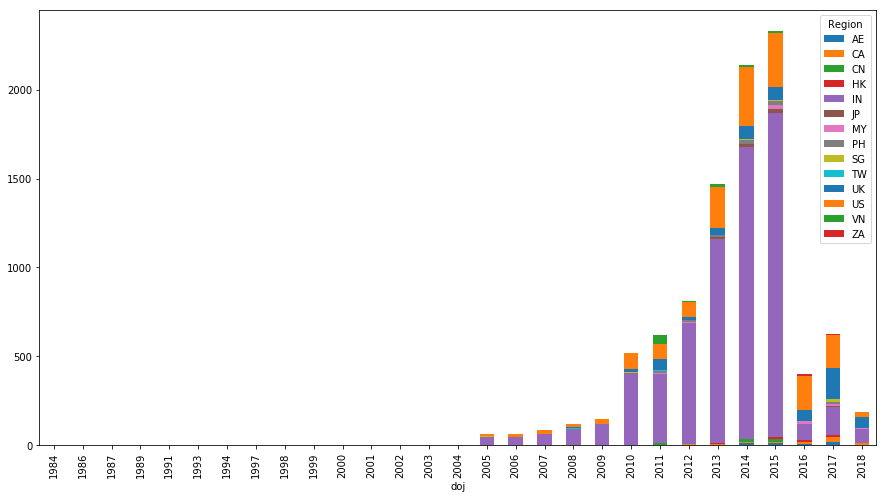

In [19]:

df_year_location_graph.plot(figsize=(15,8),kind='bar', stacked=True)

In [20]:
df_year_location_graph.iplot(title="Demand per Region( Stacked Graph )",xTitle="Year-->",yTitle="Demand-->",kind='bar',barmode='stack', filename='cugrouped-bar-chart')

In [21]:
df_year_location_graph.iplot(title="Demand per Region( Scatter graph )",xTitle="Year-->",yTitle="Demand-->",kind='scatter', filename='cugrouped-line-chart')

### Year vs Designation Analysis

In [22]:
# grouping based on region and other setup
demand_by_year_pos=df_demand.groupby([df_demand.doj.dt.year,"Designation"])["unique_id"].count()
df_year_designation=pd.DataFrame(demand_by_year_pos).reset_index()
df_year_designation_graph = df_year_designation.set_index(['doj', 'Designation']).unstack()
df_year_designation_graph.columns=df_year_designation_graph.columns.get_level_values(1)

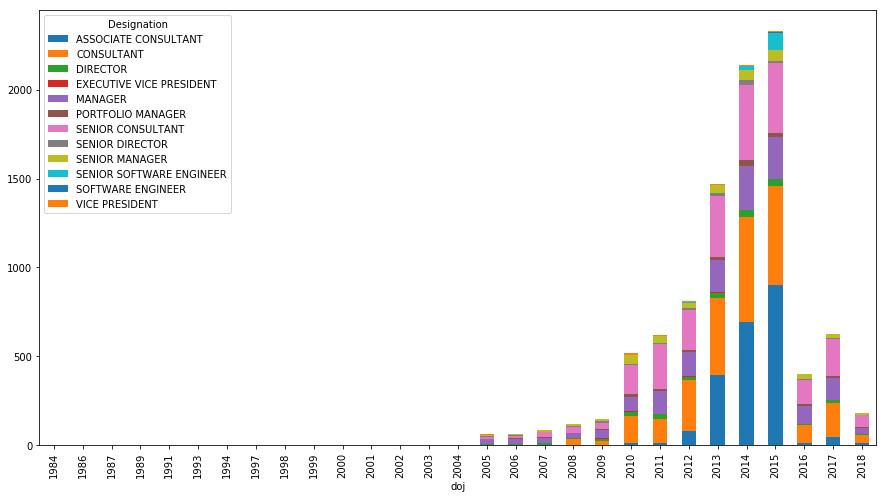

In [23]:

df_year_designation_graph.plot(figsize=(15,8),kind='bar', stacked=True)

In [24]:
df_year_designation_graph.iplot(title="Demand per Designation( Stacked Graph )",xTitle="Year-->",yTitle="Demand-->",kind='bar',barmode='stack', filename='desiggrouped-bar-chart')

In [25]:
df_year_designation_graph.iplot(title="Demand per Designation( Scatter graph )",xTitle="Year-->",yTitle="Demand-->",kind='scatter', filename='cugrouped-line-chart')

In [26]:
df_year_designation.Designation.unique()

array(['SENIOR DIRECTOR', 'CONSULTANT', 'VICE PRESIDENT', 'DIRECTOR',
       'EXECUTIVE VICE PRESIDENT', 'SENIOR CONSULTANT', 'SENIOR MANAGER',
       'PORTFOLIO MANAGER', 'MANAGER', 'ASSOCIATE CONSULTANT',
       'SENIOR SOFTWARE ENGINEER', 'SOFTWARE ENGINEER'], dtype=object)

## Monthly Analysis

In [27]:
df_month_year=df_demand.resample("M", how='count',on="doj")

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...).count()



In [64]:
df_month_year

,unique_id
doj,
1984-11-30,1
1984-12-31,0
1985-01-31,0
1985-02-28,0
1985-03-31,0
1985-04-30,0
1985-05-31,0
1985-06-30,0
1985-07-31,0


In [28]:
type(df_month_year)

pandas.core.frame.DataFrame

In [29]:
df_month_year=df_month_year.unique_id

In [30]:
df_month_year=pd.DataFrame(df_month_year)

In [31]:
df_month_year.unique_id.sum()

9604

## Time series Analysis

### Divide demand data to train and test set

In [32]:
# sort demand
df_demand_sorted=df_demand.sort_values(by="doj")

In [33]:
# 80-20 split to train and test set
split_index=int(0.8*df_demand_sorted.shape[0])
train=df_demand_sorted[:split_index]
test=df_demand_sorted[split_index:]

### divide demand by month

In [34]:
train_by_month=train.resample("M", how='count',on="doj")
test_by_month=test.resample("M", how='count',on="doj")
test_by_month=test_by_month[:-1]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...).count()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...).count()



### plotting month wise demand graph

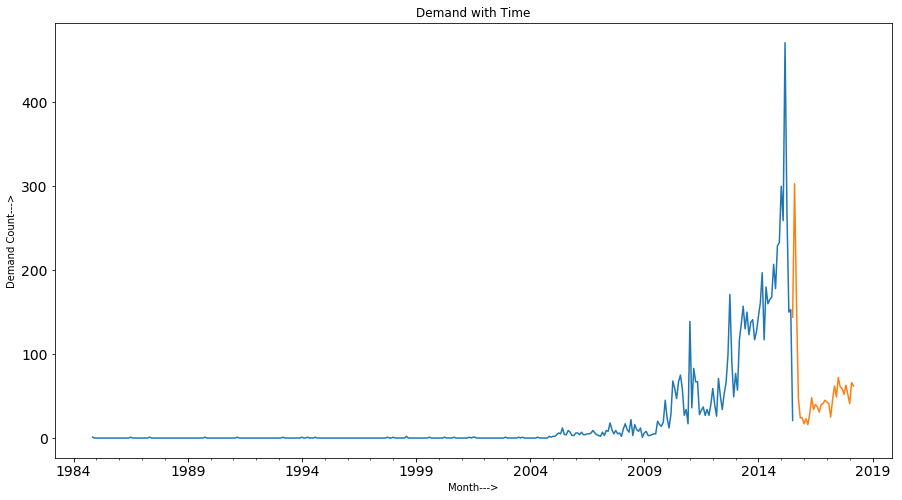

In [35]:
#Plotting data
train_by_month.unique_id.plot(figsize=(15,8),label="as", title= 'Demand with Time', fontsize=14)
test_by_month.unique_id.plot(figsize=(15,8), title= 'Demand with Time', fontsize=14)
plt.ylabel('Demand Count--->')
plt.xlabel('Month--->')

plt.show()

# Interactive graph
layout = go.Layout(
    title='Present Demand per month Graph',
    yaxis=dict(title='Demand'),
    xaxis=dict(title='Time in months')
)

data1 = go.Scatter( x=train_by_month.index, y=train_by_month.unique_id, name="present test data" )
data2 = go.Scatter( x=test_by_month.index, y=test_by_month.unique_id,name="present train data" )

fig = go.Figure(data=[data1,data2], layout=layout)
py.iplot(fig, filename='pandas-time-series')

#Interactive links


### Moving average

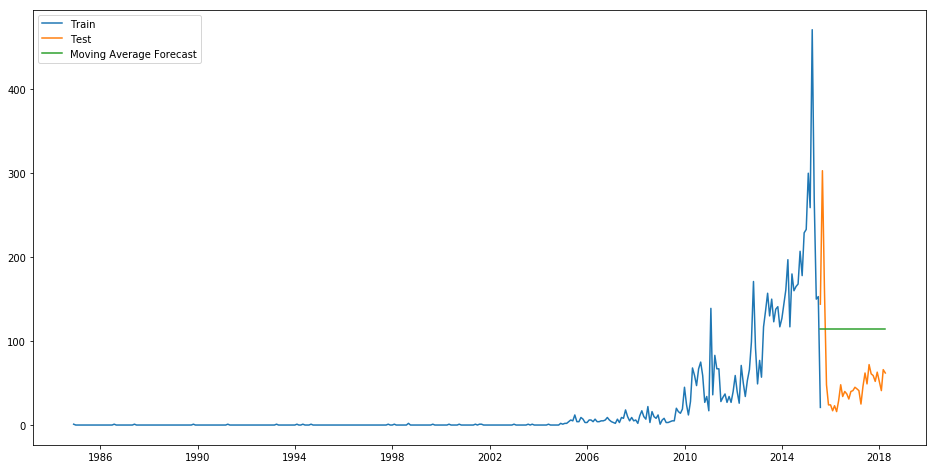

RMS value : 77.6234271299196


In [36]:
predicted_moving_avg = test_by_month.copy()
predicted_moving_avg['moving_avg_forecast'] = train_by_month.unique_id.rolling(60).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(train_by_month['unique_id'], label='Train')
plt.plot(test_by_month['unique_id'], label='Test')
plt.plot(predicted_moving_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

# Root mean Square error
rms = math.sqrt(mean_squared_error(test_by_month.unique_id, predicted_moving_avg.moving_avg_forecast))
print("RMS value : {}".format(rms))

# Interactive graph
layout = go.Layout(
    title='Predicted Demand by moving average',
    yaxis=dict(title='Demand'),
    xaxis=dict(title='Time in months')
)

data1 = go.Scatter( x=train_by_month.index, y=train_by_month.unique_id, name="present test data" )
data2 = go.Scatter( x=test_by_month.index, y=test_by_month.unique_id,name="present train data" )
data3 = go.Scatter( x=predicted_moving_avg.index, y=predicted_moving_avg['moving_avg_forecast'],name='Moving Average Forecast' )

fig = go.Figure(data=[data1,data2,data3], layout=layout)
py.iplot(fig, filename='prediction-moving-average')

### Holt's Linear Method

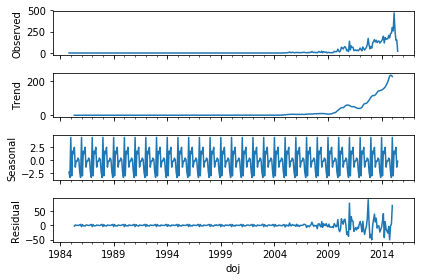

In [37]:
sm.tsa.seasonal_decompose(train_by_month.unique_id).plot()
result = sm.tsa.stattools.adfuller(train_by_month.unique_id)
plt.show()

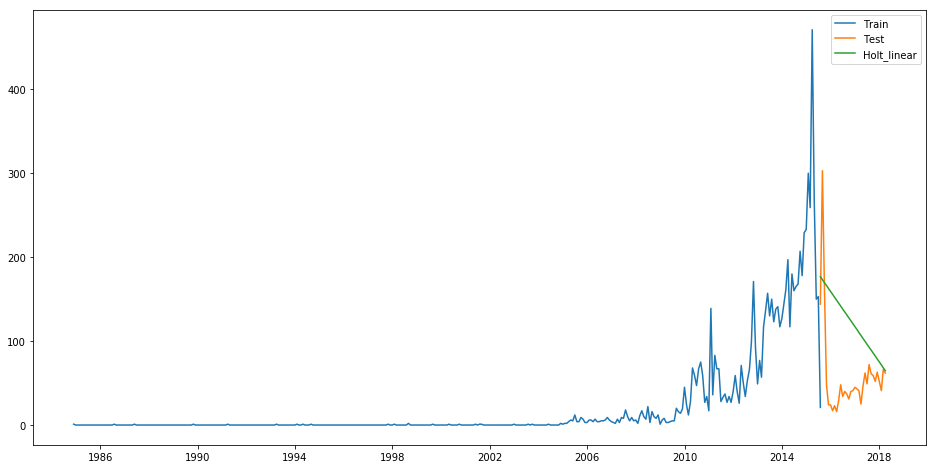

RMS  error value : 83.47406318140298


In [38]:
# Holt's Linear Method

predicted_holt_linear = test_by_month.copy()

fit1 = Holt(np.asarray(train_by_month.unique_id)).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
predicted_holt_linear['Holt_linear'] = fit1.forecast(len(test_by_month))

plt.figure(figsize=(16,8))
plt.plot(train_by_month.unique_id, label='Train')
plt.plot(test_by_month.unique_id, label='Test')
plt.plot(predicted_holt_linear['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

rms = math.sqrt(mean_squared_error(test_by_month.unique_id, predicted_holt_linear.Holt_linear))
print("RMS  error value : {}".format(rms))

# Interactive graph
layout = go.Layout(
    title='Predicted Demand by Holt Linear',
    yaxis=dict(title='Demand'),
    xaxis=dict(title='Time in months')
)

data1 = go.Scatter( x=train_by_month.index, y=train_by_month.unique_id, name="present test data" )
data2 = go.Scatter( x=test_by_month.index, y=test_by_month.unique_id,name="present train data" )
data3 = go.Scatter( x=predicted_holt_linear.index, y=predicted_holt_linear['Holt_linear'],name='Holt_linear Forecast' )

fig = go.Figure(data=[data1,data2,data3], layout=layout)
py.iplot(fig, filename='prediction-holt-linear')

### Holt Winter method

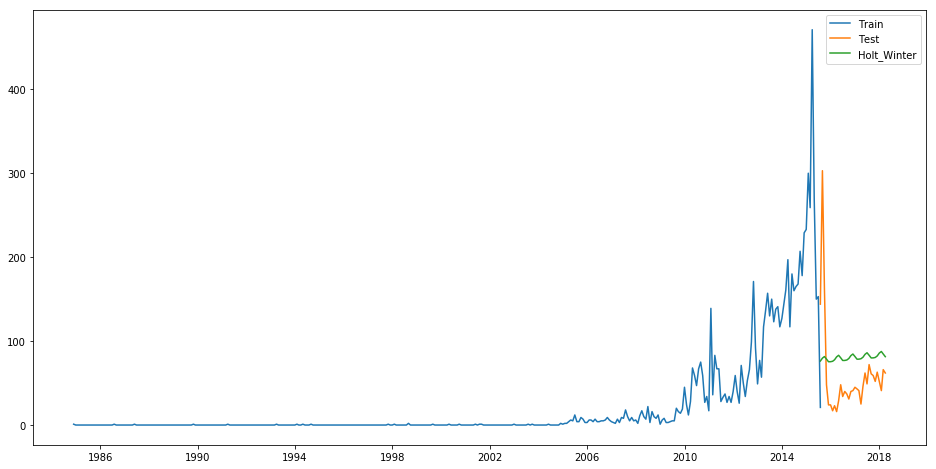

RMS value : 57.48020116792902


In [39]:

predicted_holt_winter = test_by_month.copy()
fit1 = ExponentialSmoothing(np.asarray(train_by_month.unique_id) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
predicted_holt_winter['Holt_Winter'] = fit1.forecast(len(test_by_month))
plt.figure(figsize=(16,8))
plt.plot( train_by_month.unique_id, label='Train')
plt.plot(test_by_month.unique_id, label='Test')
plt.plot(predicted_holt_winter['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()
rms = math.sqrt(mean_squared_error(test_by_month.unique_id, predicted_holt_winter.Holt_Winter))
print("RMS value : {}".format(rms))

# Interactive graph
layout = go.Layout(
    title='Predicted Demand by Holt Winter',
    yaxis=dict(title='Demand'),
    xaxis=dict(title='Time in months')
)

data1 = go.Scatter( x=train_by_month.index, y=train_by_month.unique_id, name="present test data" )
data2 = go.Scatter( x=test_by_month.index, y=test_by_month.unique_id,name="present train data" )
data3 = go.Scatter( x=predicted_holt_winter.index, y=predicted_holt_winter['Holt_Winter'],name='Holt Winter Forecast' )

fig = go.Figure(data=[data1,data2,data3], layout=layout)
py.iplot(fig, filename='prediction-holt-winter')

### Seasonal ARIMA

/home/kapil/.local/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



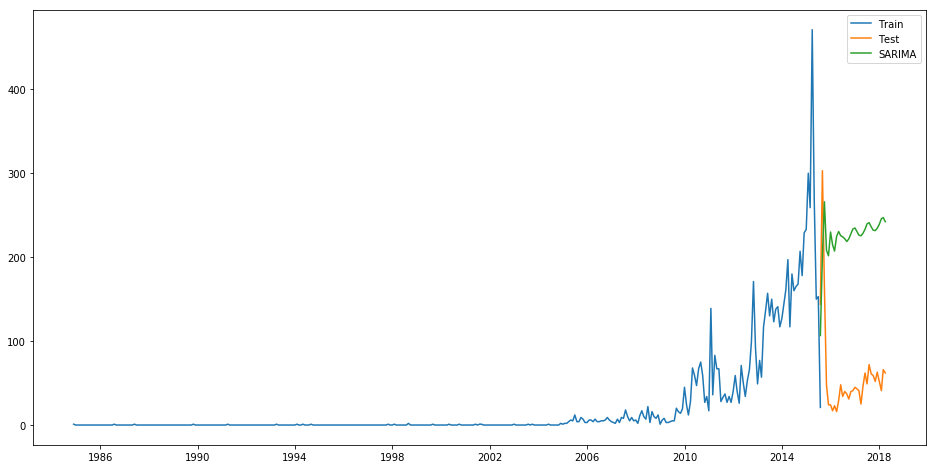

RMS value : 179.1576590632608


In [40]:
predicted_seasonal_arima = test_by_month.copy()
fit1 = sm.tsa.statespace.SARIMAX(train_by_month.unique_id, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()
predicted_seasonal_arima['SARIMA'] = fit1.predict(start=368,end=403, dynamic=True)
plt.figure(figsize=(16,8))
plt.plot( train_by_month.unique_id, label='Train')
plt.plot(test_by_month.unique_id, label='Test')
plt.plot(predicted_seasonal_arima['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

rms = math.sqrt(mean_squared_error(test_by_month.unique_id, predicted_seasonal_arima.SARIMA))
print("RMS value : {}".format(rms))

# Interactive graph
layout = go.Layout(
    title='Demand Prediction by Seasonal Arima',
    yaxis=dict(title='Demand'),
    xaxis=dict(title='Time in months')
)

data1 = go.Scatter( x=train_by_month.index, y=train_by_month.unique_id, name="present test data" )
data2 = go.Scatter( x=test_by_month.index, y=test_by_month.unique_id,name="present train data" )
data3 = go.Scatter( x=predicted_seasonal_arima.index, y=predicted_seasonal_arima['SARIMA'],name='Holt Winter Forecast' )

fig = go.Figure(data=[data1,data2,data3], layout=layout)
py.iplot(fig, filename='prediction-seasonal_arima')

## Result of Time series Analysis @ 80-20 split

- ### Moving average -- 77.6234271299196
- ### Holt Linear -- 83.47406318140298
- ### Holt Winter method -- 57.48020116792902
- ### Seasonal Arima model -- 179.1576590632608

* ## Note  
The time series hasn't provided a great result, it's because of the sudden drop in demand at the end of the year 2015-2016. So the combined moving average of previous year affects the prediction of future.
So what can we do? Ideal sol. will be to have some more recent data to allow the effect of demand peak of 2015 subside.
Or we can increase train data to be 90 percent that will take the drop into account also, but this comes at the cost of limited tests.

## Result of Time series Analysis @ 90-10 split

In [41]:
# 90-10 split to train and test set
split_index_90=int(0.90*df_demand_sorted.shape[0])
train_90=df_demand_sorted[:split_index_90]
test_90=df_demand_sorted[split_index_90:]

In [42]:
train_by_month_90=train_90.resample("M", how='count',on="doj")
test_by_month_90=test_90.resample("M", how='count',on="doj")
test_by_month_90=test_by_month_90[:-1]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...).count()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...).count()



In [43]:
test_by_month_90

,unique_id,Region,Employee Code,Last Name,doj,Designation,Status,Market Unit,SkillList,Location
doj,,,,,,,,,,
2016-09-30,21,21,21,21,21,21,21,20,21,21
2016-10-31,40,40,40,40,40,40,40,40,40,40
2016-11-30,41,41,41,41,41,41,41,41,41,41
2016-12-31,45,45,45,45,45,45,45,44,45,45
2017-01-31,43,43,43,43,43,43,43,42,43,43
2017-02-28,41,41,41,41,41,41,41,41,41,41
2017-03-31,25,25,25,25,25,25,25,24,25,25
2017-04-30,46,46,46,46,46,46,46,46,46,46
2017-05-31,62,62,62,62,62,62,62,60,62,62


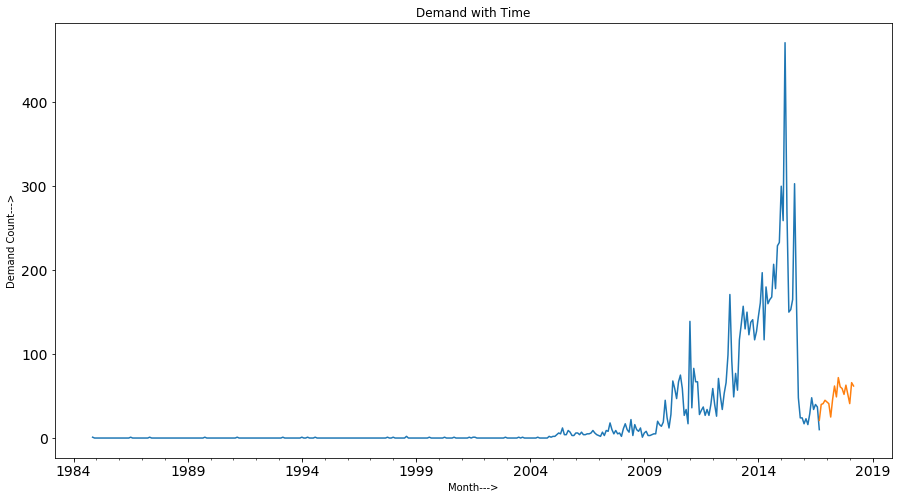

In [44]:
#Plotting data
train_by_month_90.unique_id.plot(figsize=(15,8),label="as", title= 'Demand with Time', fontsize=14)
test_by_month_90.unique_id.plot(figsize=(15,8), title= 'Demand with Time', fontsize=14)
plt.ylabel('Demand Count--->')
plt.xlabel('Month--->')

plt.show()

# Interactive graph
layout = go.Layout(
    title='Present Demand per month Graph',
    yaxis=dict(title='Demand'),
    xaxis=dict(title='Time in months')
)

data1 = go.Scatter( x=train_by_month_90.index, y=train_by_month_90.unique_id, name="present train data" )
data2 = go.Scatter( x=test_by_month_90.index, y=test_by_month_90.unique_id,name="present test data",mode = 'lines' )

fig = go.Figure(data=[data1,data2], layout=layout)
py.iplot(fig, filename='present_graph_91')

Moving avg. RMS value : 70.1242656402115
Holt linear RMS value : 146.06096582776428
Holt winter RMS value : 29.015957296157453


/home/kapil/.local/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Seasonal RMS value : 16.430577078652995


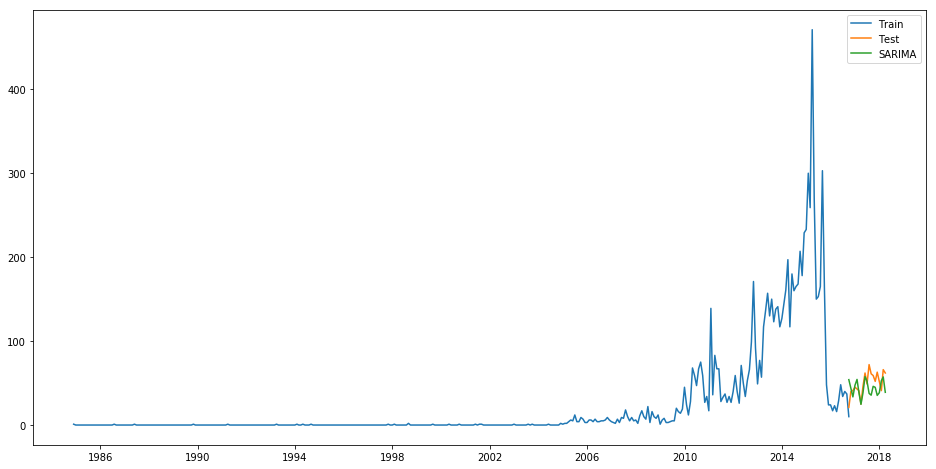

In [45]:
predicted_moving_avg_90 = test_by_month_90.copy()
predicted_moving_avg_90['moving_avg_forecast'] = train_by_month_90.unique_id.rolling(60).mean().iloc[-1]
rms = math.sqrt(mean_squared_error(test_by_month_90.unique_id, predicted_moving_avg_90.moving_avg_forecast))
print("Moving avg. RMS value : {}".format(rms))

# Holt linear
predicted_holt_linear_90 = test_by_month_90.copy()
fit1 = Holt(np.asarray(train_by_month_90.unique_id)).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
predicted_holt_linear_90['Holt_linear'] = fit1.forecast(len(test_by_month_90))
rms = math.sqrt(mean_squared_error(test_by_month_90.unique_id, predicted_holt_linear_90.Holt_linear))
print("Holt linear RMS value : {}".format(rms))

# Holt winter
predicted_holt_winter_90 = test_by_month_90.copy()
fit1 = ExponentialSmoothing(np.asarray(train_by_month_90.unique_id) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
predicted_holt_winter_90['Holt_Winter'] = fit1.forecast(len(test_by_month_90))
rms = math.sqrt(mean_squared_error(test_by_month_90.unique_id, predicted_holt_winter_90.Holt_Winter))
print("Holt winter RMS value : {}".format(rms))

# Seasonal ARIMA
predicted_sarima_90 = test_by_month_90.copy()
fit1 = sm.tsa.statespace.SARIMAX(train_by_month_90.unique_id, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()

predicted_sarima_90['SARIMA'] = fit1.predict(start=train_by_month_90.shape[0]-1,end=train_by_month_90.shape[0]+test_by_month_90.shape[0], dynamic=True)
rms = math.sqrt(mean_squared_error(test_by_month_90.unique_id, predicted_sarima_90.SARIMA))
print("Seasonal RMS value : {}".format(rms))

# Seasaonal Arima Graph
plt.figure(figsize=(16,8))
plt.plot( train_by_month_90.unique_id, label='Train')
plt.plot(test_by_month_90.unique_id, label='Test')
plt.plot(predicted_sarima_90['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

# Interactive graph
layout = go.Layout(
    title='Demand Prediction by Seasonal Arima',
    yaxis=dict(title='Demand'),
    xaxis=dict(title='Time in months')
)

data1 = go.Scatter( x=train_by_month_90.index, y=train_by_month_90.unique_id, name="present test data",mode='lines' )
data2 = go.Scatter( x=test_by_month_90.index, y=test_by_month_90.unique_id,name="present train data",mode='lines' )
data3 = go.Scatter( x=predicted_sarima_90.index, y=predicted_sarima_90['SARIMA'],name='Seasonal Arima Forecast',mode='lines' )

fig = go.Figure(data=[data1,data2,data3], layout=layout)
py.iplot(fig, filename='prediction-seasonal_arima_90')


## Result @ 90-10 split
- ### Moving average -- 70.1242656402115
- ### Holt Linear -- 146.06096582776428
- ### Holt Winter method -- 29.015957296157453
- ### Seasonal Arima model -- 16.430577078652995

## Predicting future demands with Seasonal ARIMA 

In [46]:
df_demand_sorted

,unique_id,Region,Employee Code,Last Name,doj,Designation,Status,Market Unit,SkillList,Location
9839,9839,US,20810,WHINERY JR,1984-11-12,SENIOR DIRECTOR,Billable,OTHER,OpenText,Hartford
2042,2042,US,49466,DOYLE,1986-07-14,CONSULTANT,Billable,INS,Tableau,Bhubaneswar
6078,6078,US,72370,OLDROYD,1987-05-01,SENIOR DIRECTOR,Billable,INS,Selenium,Bhubaneswar
1172,1172,US,81631,CANTOR,1989-10-02,VICE PRESIDENT,Billable,OTHER,Temenos,Noida
4592,4592,US,25625,KUTA,1991-03-18,CONSULTANT,Billable,APAC,Temenos,Noida
9827,9827,US,88804,WARDMAN,1993-03-08,DIRECTOR,Billable,NaN,(T) Data Integration,Noida
7488,7488,US,79332,ROSTRATTER,1994-01-09,VICE PRESIDENT,Billable,BANK,BLUE PRISM,Pune
56,56,US,59924,ADHIA,1994-04-11,VICE PRESIDENT,Billable,INS,Selenium,Noida
2081,2081,US,71733,DUGAN,1994-08-29,EXECUTIVE VICE PRESIDENT,Billable,INS,Java (Multi Skilled),Bhubaneswar
2347,2347,US,87192,GANDLA,1997-10-13,VICE PRESIDENT,Billable,BANK,Agile,Gurgaon


In [47]:
# create train dataset ordered by month
train_full_data=df_demand_sorted.resample("M", how='count',on="doj")

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...).count()



In [48]:
train_full_data.tail(5)

,unique_id,Region,Employee Code,Last Name,doj,Designation,Status,Market Unit,SkillList,Location
doj,,,,,,,,,,
2017-12-31,52,52,52,52,52,52,52,52,52,52
2018-01-31,41,41,41,41,41,41,41,41,41,41
2018-02-28,66,66,66,66,66,66,66,66,66,66
2018-03-31,62,62,62,62,62,61,62,62,62,62
2018-04-30,20,20,20,20,20,13,20,20,20,20


### Note  
In sorted dataframe we can see that the last month has only entries for 12 days, so we should remove that month's data while training the model

In [49]:
# remove last month entry
train_full_data=train_full_data[:-1]

In [50]:
train_full_data.tail(5)

,unique_id,Region,Employee Code,Last Name,doj,Designation,Status,Market Unit,SkillList,Location
doj,,,,,,,,,,
2017-11-30,63,63,63,63,63,63,63,59,63,63
2017-12-31,52,52,52,52,52,52,52,52,52,52
2018-01-31,41,41,41,41,41,41,41,41,41,41
2018-02-28,66,66,66,66,66,66,66,66,66,66
2018-03-31,62,62,62,62,62,61,62,62,62,62


## Train ARIMA on complete dataset

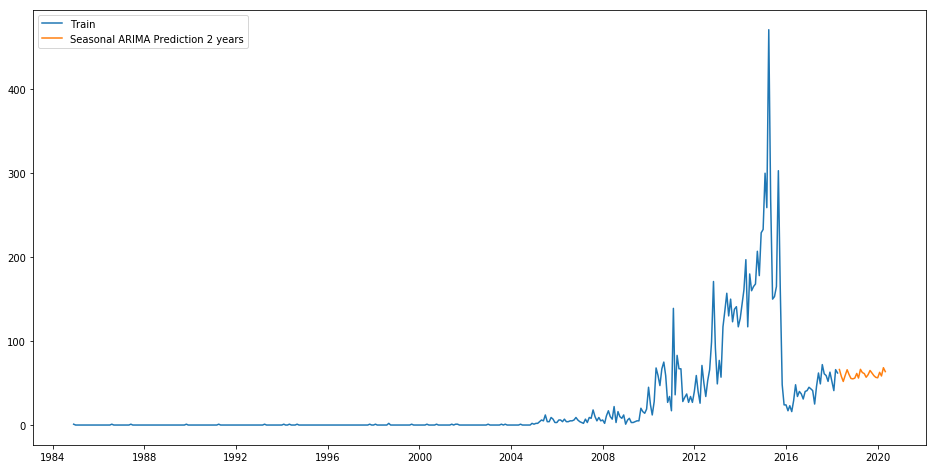

In [51]:
# Seasonal ARIMA
fit1 = sm.tsa.statespace.SARIMAX(train_full_data.unique_id, order=(2, 1, 4),seasonal_order=(0,1,1,12)).fit()

two_year_prediction = fit1.predict(start=train_full_data.shape[0],end=train_full_data.shape[0]+24, dynamic=True)
plt.figure(figsize=(16,8))
plt.plot( train_full_data.unique_id, label='Train')
plt.plot(two_year_prediction, label='Seasonal ARIMA Prediction 2 years')
plt.legend(loc='best')
plt.show()

# Interactive graph
layout = go.Layout(
    title='Future Demand Prediction by Seasonal Arima',
    yaxis=dict(title='Demand'),
    xaxis=dict(title='Time in months')
)

data1 = go.Scatter( x=train_full_data.index, y=train_full_data.unique_id, name="present data",mode='lines' )
data2 = go.Scatter( x=two_year_prediction.index, y=two_year_prediction.tolist(),name="2 year prediction",mode='lines' )

fig = go.Figure(data=[data1,data2], layout=layout)
py.iplot(fig, filename='future_prediction-seasonal_arima')


## Task 1

In [52]:
# Two year prediction for demand
two_year_prediction

2018-04-30    66.125080
2018-05-31    57.869706
2018-06-30    51.910134
2018-07-31    59.125660
2018-08-31    65.879666
2018-09-30    60.239075
2018-10-31    55.455108
2018-11-30    55.038171
2018-12-31    55.887890
2019-01-31    61.461725
2019-02-28    55.990906
2019-03-31    66.359077
2019-04-30    62.548876
2019-05-31    61.323352
2019-06-30    56.935349
2019-07-31    59.979066
2019-08-31    65.005546
2019-09-30    62.034174
2019-10-31    58.862233
2019-11-30    56.813328
2019-12-31    56.287372
2020-01-31    62.800596
2020-02-29    58.435889
2020-03-31    68.310378
2020-04-30    63.649978
Freq: M, dtype: float64

## Variable Factors aand their possible affects

- ### Total bench budget --> 5.76 million
Increasing the total bench budget will allow more people to be on the bench.
- ### Avg Cost per resource per month on bench --> 685
Changing this will again affect the number of people allowed on the bench
- ### Current Bench strength --> 400
This will inversly affect the budget
- ### Attrition --> 20 percent
This will affect our optimization strategy and the predicted supply. Assuming Attrition in demand is taken care as it adds to the total requirement. So we need to take care of attrition in supply.
- ### Initial headcount --> 10K
Assuming it to be constant
- ### headcount Cap --> 12K
If increased will Allow more people to be hired/benched
- ### Supply opportunity cost --> 900
This is a risk/reward variable. If increased we need to take more risk to better gain.


In [53]:
# avg bench count we can have in the given budget
5760000/(685*12)

700.7299270072992

## Supply Optimization Strategy

- Since lost opportunity cost is virtual but ideal resource cost is real, we would prefer to keep actual supply a little lower than the demand predicted by our model by  a safe_cutoff percentage, initially [ `10 percent x (cost_per_resource_per_month/supply_lost_cost)` ], This ratio makes sure that we get pain vs gain relation. For example if `supply_lost_cost` increases to much it becomes logical to take more risks and hire more people.

- Keeping attrition in mind, attrition would also affect our supply chain, so we must push our supply by `20 percent` of the monthly requirement.
- total_bench_budget will be used to make sure the total cost remains under the cap if the cost_per_resource is changed.

- Headcount cap will make sure the total number of employees remain under 12000 and this may be increased in case of a sudden demand/growth.

## Initializing variable factors - Task 2

In [54]:
total_bench_budget=5760000
cost_per_resource_per_month=685
current_bench_strength=400
attrition=20
initial_headcount=10000
headcount_cap=12000
supply_lost_cost=900

# this variable is used to evaluate Net loss of money due to accuracy error
accuracy_error=10

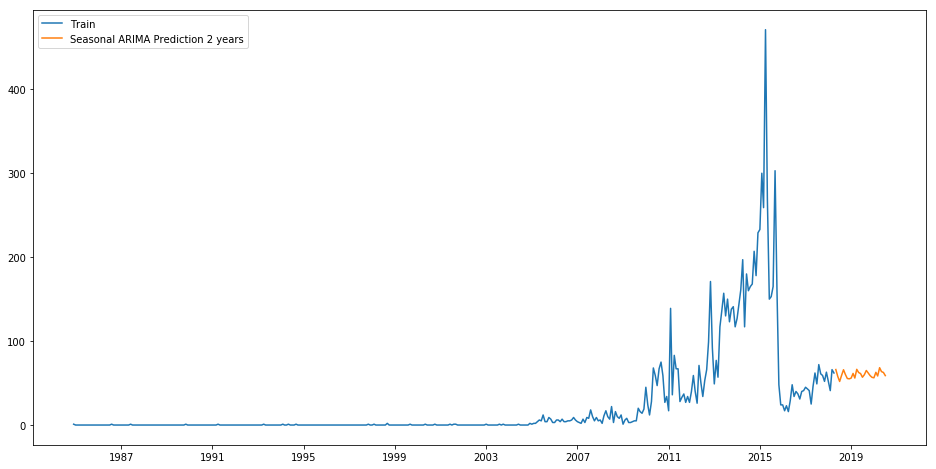

Total Head Count after a Year: 10711.342197989854
final head count: 10711.342197989854 is below the allowed size of 12000
Cost if our supply is higher than demand by 10 percentage: 48726.940562305026 dollors
Cost of Opportunity loss if our supply is lower than demand by 10 percentage: 64020.79781908689 dollors


,demand,optimal_demand
2018-04-30,66.125080,71.800816
2018-05-31,57.869706,62.836856
2018-06-30,51.910134,56.365754
2018-07-31,59.125660,64.200612
2018-08-31,65.879666,71.534338
2018-09-30,60.239075,65.409595
2018-10-31,55.455108,60.215005
2018-11-30,55.038171,59.762281
2018-12-31,55.887890,60.684934
2019-01-31,61.461725,66.737190


Predicted actual demand and adjusted demand values


In [55]:
# We will use Seasonal ARIMA model. 
# Train on all the data we have. 
# Predict for the next 12-24 months and then optimize the result that we get 
# based on the values from our variables initialized above.

# Seasonal ARIMA
fit1 = sm.tsa.statespace.SARIMAX(train_full_data.unique_id, order=(2, 1, 4),seasonal_order=(0,1,1,12)).fit()

two_year_prediction = fit1.predict(start=train_full_data.shape[0],end=train_full_data.shape[0]+26, dynamic=True)
plt.figure(figsize=(16,8))
plt.plot( train_full_data.unique_id, label='Train')
plt.plot(two_year_prediction, label='Seasonal ARIMA Prediction 2 years')
plt.legend(loc='best')
plt.show()

# Interactive graph
layout = go.Layout(
    title='Future Demand Prediction by Seasonal Arima',
    yaxis=dict(title='Demand'),
    xaxis=dict(title='Time in months')
)

data1 = go.Scatter( x=train_full_data.index, y=train_full_data.unique_id, name="present data",mode='lines' )
data2 = go.Scatter( x=two_year_prediction.index, y=two_year_prediction.tolist(),name="2 year prediction",mode='lines' )

fig = go.Figure(data=[data1,data2], layout=layout)
display(py.iplot(fig, filename='future_prediction-seasonal_arima'))

# two_year_prediction
prediction_df=pd.DataFrame(two_year_prediction,columns=["demand"])


# Optimizing the prediction supply values
safe_cutoff=15*(cost_per_resource_per_month/supply_lost_cost)
adjusted_cutoff=attrition-safe_cutoff

# Adjusted Demand
prediction_df["optimal_demand"]=prediction_df.demand.apply(lambda x: x+ x*(adjusted_cutoff*0.01))

# Sanity check on headcount cap
final_head_count=initial_headcount+sum(prediction_df.demand.tolist()[:12])
print("Total Head Count after a Year: {}".format(final_head_count))

if final_head_count<headcount_cap:
    print("final head count: {} is below the allowed size of {}".format(final_head_count,headcount_cap))
else:
    print("final head count: {} is above the allowed size of {}".format(final_head_count,headcount_cap))

# Monetory Loss due to accuracy error if supply is higher
print("Cost if our supply is higher than demand by {} percentage: {} dollors"
      .format(accuracy_error,sum((prediction_df.demand*(accuracy_error*0.01*cost_per_resource_per_month)).tolist()[:12])))
 
# Opportunity Loss due to accuracy error if supply is lower than demand
print("Cost of Opportunity loss if our supply is lower than demand by {} percentage: {} dollors"
      .format(accuracy_error,sum((prediction_df.demand*(accuracy_error*0.01*supply_lost_cost)).tolist()[:12])))
 
    
display(prediction_df)
print("Predicted actual demand and adjusted demand values")



## Task 3 S(N)=D(N+2)

In [56]:
# Supply has to be two month in advance S(N)=D(N+2), shifting demand accordingly
prediction_df["shifted_supply_2_month"]=prediction_df.optimal_demand.tolist()[2:]+[60,60]

# Converting prediction to integer
prediction_df[['demand', 'optimal_demand','shifted_supply_2_month']] = prediction_df[['demand', 'optimal_demand','shifted_supply_2_month']].astype(int)
prediction_df.to_csv("2_year_prediction.csv")
display(prediction_df)

,demand,optimal_demand,shifted_supply_2_month
2018-04-30,66,71,56
2018-05-31,57,62,64
2018-06-30,51,56,71
2018-07-31,59,64,65
2018-08-31,65,71,60
2018-09-30,60,65,59
2018-10-31,55,60,60
2018-11-30,55,59,66
2018-12-31,55,60,60
2019-01-31,61,66,72


### something more


In [57]:
demand_by_year_desig=df_demand.groupby([df_demand.doj.dt.year,"Region","Designation"])["unique_id"].count()

## Yearly demand in a region  per Designation

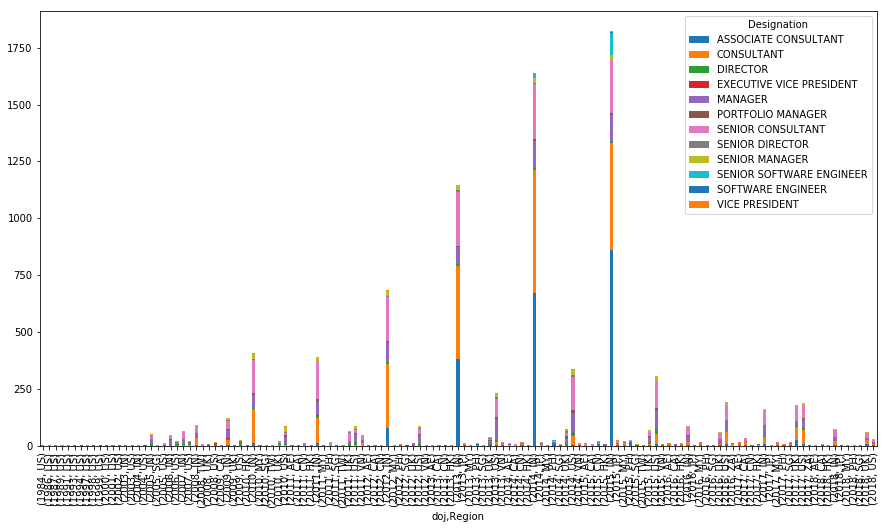

In [58]:
# grouping based on region and other setup
demand_by_year_desig=df_demand.groupby([df_demand.doj.dt.year,"Region","Designation"])["unique_id"].count()
df_year_location_desig=pd.DataFrame(demand_by_year_desig).reset_index()
df_year_location_desig_graph = df_year_location_desig.set_index(['doj', 'Region',"Designation"]).unstack()
df_year_location_desig_graph.columns=df_year_location_desig_graph.columns.get_level_values(1)
df_year_location_desig_graph.plot(figsize=(15,8),kind='bar', stacked=True)
display(df_year_location_desig_graph.iplot(title="Demand per Region per Designation( Stacked Graph )",xTitle="Year-->",yTitle="Demand-->",kind='bar',barmode='stack', filename='desig_cugrouped-bar-chart'))
display(df_year_location_desig_graph.iplot(title="Demand per Region per Designation( Line Graph )",xTitle="Year-->",yTitle="Demand-->",kind='scatter', filename='desig_cugrouped-bar-chart'))